In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob

In [3]:
# initial parameters
epochs = 100
lr = 1e-3
batch_size = 64
img_dims = (96,96,3)

data = []
labels = []

# load image files from the dataset
dir = "/content/drive/My Drive/FaceRecognition/train"

image_files = [f for f in glob.glob(dir + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

# converting images to arrays and labelling the categories
for img in image_files:

    image = cv2.imread(img)
    
    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split('/content/drive/My Drive/FaceRecognition/train/Female') # C:\Files\gender_dataset_face\woman\face_1162.jpg
    if label == "Female":
        label = 1
    else:
        label = 0
        
    labels.append([label]) # [[1], [0], [0], ...]


In [4]:
# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [5]:
# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)

In [6]:
trainY = to_categorical(trainY, num_classes=2) # [[1, 0], [0, 1], [0, 1], ...]
testY = to_categorical(testY, num_classes=2)

In [7]:
# augmenting datset 
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

In [8]:
# define model
def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first": #Returns a string, either 'channels_first' or 'channels_last'
        inputShape = (depth, height, width)
        chanDim = 1
    
    # The axis that should be normalized, after a Conv2D layer with data_format="channels_first", 
    # set axis=1 in BatchNormalization.

    model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=1))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=1))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model

# build model
model = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2],
                            classes=2)
# compile the model
opt = Adam(lr=lr, decay=lr/epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the model
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs, verbose=1)

# save the model to disk
model.save('gender_detection.model')

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
12/12 [==============================] - 3s 209ms/step - loss: 0.9217 - accuracy: 0.5759 - val_loss: 0.7952 - val_accuracy: 0.0149
Epoch 2/100
12/12 [==============================] - 2s 155ms/step - loss: 0.6886 - accuracy: 0.6924 - val_loss: 0.9643 - val_accuracy: 0.0000e+00
Epoch 3/100
12/12 [==============================] - 2s 154ms/step - loss: 0.5387 - accuracy: 0.8089 - val_loss: 1.3586 - val_accuracy: 0.0000e+00
Epoch 4/100
12/12 [==============================] - 2s 154ms/step - loss: 0.4097 - accuracy: 0.9065 - val_loss: 1.2501 - val_accuracy: 0.0249
Epoch 5/100
12/12 [==============================] - 2s 161ms/step - loss: 0.2857 - accuracy: 0.9743 - val_loss: 0.7773 - val_accuracy: 0.1144
Epoch 6/100
12/12 [==============================] - 2s 158ms/step - loss: 0.2113 - accuracy: 0.9837 - val_loss: 0.4748 - val_accuracy: 1.0000
Epoch 7/100
12/12 [==============================] - 2s 15

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0

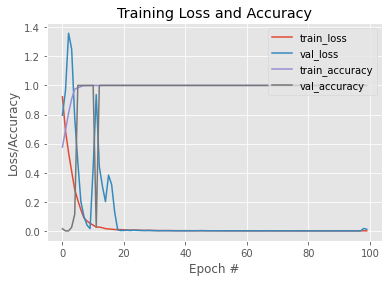

In [10]:
# plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_accuracy")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

# save plot to disk
plt.savefig('plot.png')

In [11]:
# step-1: read the data
img = cv2.imread('/content/drive/My Drive/FaceRecognition/train/testsubject1.jpg') # BGR

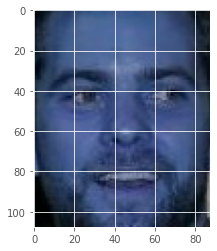

In [12]:
plt.imshow(img)

In [13]:
img = cv2.resize(img,(96,96))
img= img.astype('float')/ 255.0
img = img_to_array(img)
img=np.expand_dims(img,axis=0)
img.shape

(1, 96, 96, 3)

In [14]:
results = model.predict_proba(img)

Instructions for updating:
Please use `model.predict()` instead.


In [15]:
import pandas as pd

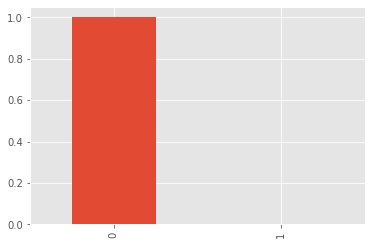

In [16]:
pd.Series(results.flatten()).plot(kind='bar')              (# 0 is male, 1 is female.)

In [17]:
img2 = cv2.imread('/content/drive/My Drive/FaceRecognition/train/testsbjet2.jpg') # BGR

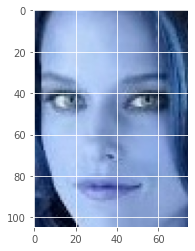

In [18]:
plt.imshow(img2)

In [19]:
img2 = cv2.resize(img2,(96,96))
img2= img2.astype('float')/ 255.0
img2 = img_to_array(img2)
img2=np.expand_dims(img2,axis=0)
img2.shape

(1, 96, 96, 3)

In [20]:
results2 = model.predict_proba(img2)

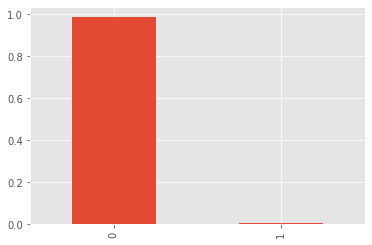

In [21]:
pd.Series(results2.flatten()).plot(kind='bar')